In [3]:
import pandas as pd
import numpy as np


# **1. Data & Packages**
For this example, we use the famous 20 Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics. Using Scikit-Learn, we can quickly download and prepare the data:

In [1]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

If you want to speed up training, you can select the subset train as it will decrease the number of posts you extract.

**NOTE:** If you want to apply topic modeling not on the entire document but on the paragraph level, I would suggest splitting your data before creating the embeddings.

# **2. Embeddings**
The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.

How you generate the BERT embeddings for a document is up to you. However, I prefer to use the sentence-transformers package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.

Install the package with pip install sentence-transformers before generating the document embeddings. If you run into issues installing this package, then it is worth installing Pytorch first.

Then, run the following code to transform your documents in 512-dimensional vectors:

In [16]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 4.9 MB 28.8 MB/s 
     |████████████████████████████████| 1.3 MB 54.0 MB/s 
     |████████████████████████████████| 120 kB 43.6 MB/s 
     |████████████████████████████████| 6.6 MB 33.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=c2af39619dd6bbfe25147ae1ff640f4925e3be8bee17dc5ae7cdcb8a434ee215
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [17]:
%%time
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

CPU times: user 57min 20s, sys: 23 s, total: 57min 43s
Wall time: 58min 30s


We are using Distilbert as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.

NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

# **3. Clustering**
We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

## **UMAP**
Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

Install the package with pip install umap-learn before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [5]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 21.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=65abd588c2e5efaf401df63a51293fa496158abdde23475852645b2c214ef5b7
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=2406a1c25383822844ec567f6e3acdfab442eeebc6271dba265c7c3168782f29
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [18]:

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

## **HDBSAN**
After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

Install the package with pip install hdbscan then create the clusters:

In [7]:
pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2340325 sha256=2a820e1e020ff9ac54bcc9c7bbfe159d97771ff8c1b496d5729ddb52fb0f56f2
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [19]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

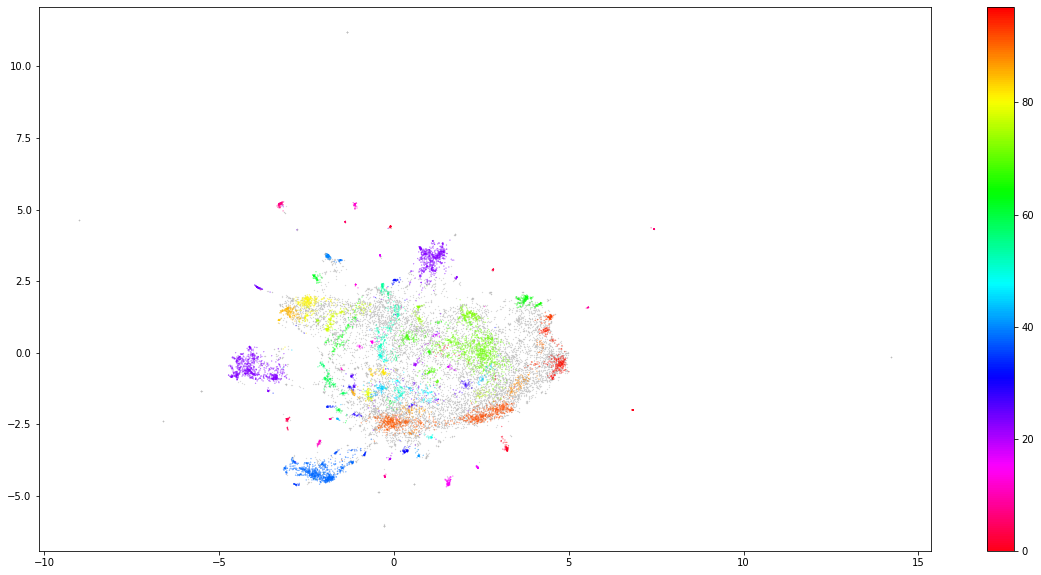

In [20]:

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

It is difficult to visualize the individual clusters due to the number of topics generated (~55). However, we can see that even in 2-dimensional space some local structure is kept.

NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

4. Topic Creation
What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

## **c-TF-IDF**
To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [21]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Then, we apply the class-based TF-IDF:

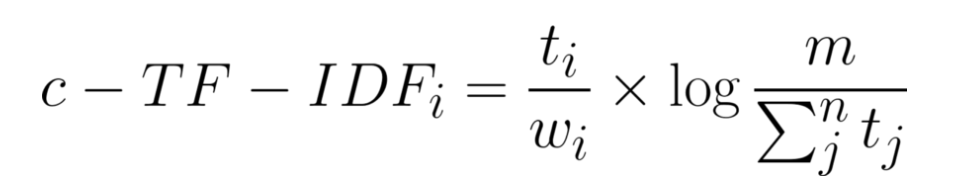

Where the frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n.

In [22]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

## **Topic Representation**
In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [23]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,9973
24,23,1554
39,38,844
72,71,839
93,92,451
92,91,430
82,81,226
97,96,182
73,72,180
86,85,154


We can use topic_sizes to view how frequent certain topics are:

In [24]:
topic_sizes

,Topic,Size
0,-1,9973
24,23,1554
39,38,844
72,71,839
93,92,451
...,...,...
49,48,17
67,66,16
57,56,16
38,37,15


The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

We can see that topics 7, 43, 12, and 41 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:

In [25]:
top_n_words[7][:10]

[('turkish', 0.03570880088504616),
 ('armenian', 0.03408319590639613),
 ('armenians', 0.02794455160206472),
 ('serdar', 0.022355124499069064),
 ('argic', 0.02224076466983574),
 ('turks', 0.021133457903161214),
 ('genocide', 0.02036182103060947),
 ('armenia', 0.018058139929457297),
 ('soviet', 0.01756512439727445),
 ('zuma', 0.016429270856931036)]

In [26]:
top_n_words[43][:10]

[('jaeger', 0.0966033144386416),
 ('gregg', 0.08238588052526023),
 ('islamic', 0.06275949391990812),
 ('buphy', 0.054599965861415974),
 ('bu', 0.05116983232666744),
 ('khomeini', 0.04924464066159974),
 ('islam', 0.04043721155895044),
 ('qur', 0.037535035579658385),
 ('rushdie', 0.03597146895518638),
 ('allah', 0.02772158949833578)]

In [27]:
top_n_words[12][:10]

[('president', 0.04898889143004916),
 ('stephanopoulos', 0.04345814167594405),
 ('mr', 0.033435014225687384),
 ('myers', 0.030561000229369226),
 ('ms', 0.020401947958659995),
 ('jobs', 0.016589397925884455),
 ('secretary', 0.01380294159068847),
 ('going', 0.013766686193947277),
 ('clinton', 0.013305071336068472),
 ('dee', 0.012928856680161879)]

In [28]:
top_n_words[41][:10]

[('fi', 0.07035850641376834),
 ('finland', 0.06573130518506307),
 ('hut', 0.03664712141748212),
 ('helsinki', 0.029617203924834228),
 ('players', 0.02814949246310792),
 ('nhl', 0.027017040611133747),
 ('team', 0.026707610193716865),
 ('abo', 0.025717048055653207),
 ('finnish', 0.02162249699850606),
 ('mlindroos', 0.01623255990903099)]

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!

I can see sports, computers, space, and religion as clear topics that were extracted from the data.



# **5. Topic Reduction**
There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.

We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [34]:
!pip install cosine_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Topic,Size
0,-1,9973
19,18,1554
59,58,875
32,31,844
74,73,539
75,74,451
68,67,226
78,77,203
70,69,190
60,59,180


Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from **56** to **36**!

**NOTE:** We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

**TIP:** You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.